## Predict permanent magnet synchronous motor (PMSM) rotor temperature with Fedot.Industrial

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. All recordings are sampled at 2 Hz. The motor is excited by hand-designed driving cycles denoting a reference motor speed and a reference torque. Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque. This "sample" of ElectricMotorTemperature dataset was created by first splitting the measurement sessions into groups of 30 consecutive seconds, i.e. 60 timepoints. Then, used the **recorded ambient**, **coolant temperatures**, **d and q components of voltage**, **current** as predictors to form 6- dimensional time series of length 60. The target variable is the **maximum recorded rotor temperature during each respective 30-second time frame**. The resulting dataset has 22148 instances, of which 70% were sampled as training data and the remaining 30% as testing data.
Link to the dataset - https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature

In [9]:
import pandas as pd
from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.tools.loader import DataLoader
import matplotlib
from fedot_ind.api.main import FedotIndustrial

In [10]:
def evaluate_loop(api_params, finetune: bool = False):
    industrial = FedotIndustrial(**api_params)
    if finetune:
        industrial.finetune(train_data)
    else:
        industrial.fit(train_data)
    return industrial

The list of basic fedot industrial models for experiment are shown below. We are using simple linear machine learning pipelines with 3 different feature generators: Statistical, Recurrence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [16]:
initial_assumption = PipelineBuilder().add_node('quantile_extractor').add_node('treg')
params = dict(problem='regression',
                             metric='rmse',
                             timeout=60,
                             initial_assumption=initial_assumption,
                             n_jobs=2,
                            with_tuning = False,
                             logging_level=20)
dataset_name = 'ElectricMotorTemperature'
data_path = PROJECT_PATH + '/examples/data'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [12]:
train_data, test_data = DataLoader(dataset_name=dataset_name, folder=data_path).load_data()

2024-04-05 13:52:20,192 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/ElectricMotorTemperature


In [13]:
import numpy as np
features = np.array(train_data[0].tolist()).astype(float)

Lets check our data.

In [14]:
features.shape

(15503, 6, 60)

Lets visualise our predictors.

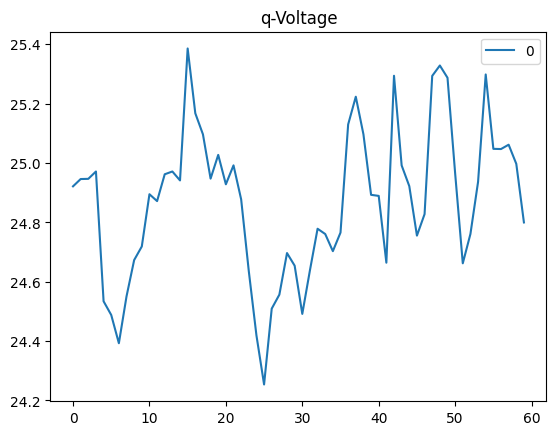

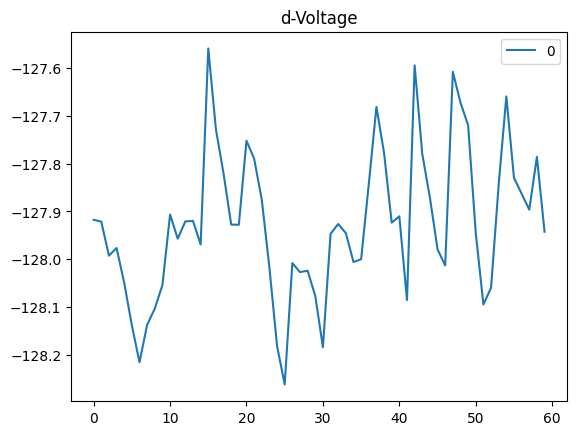

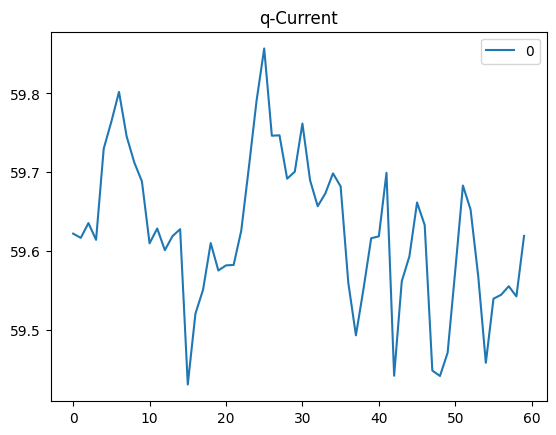

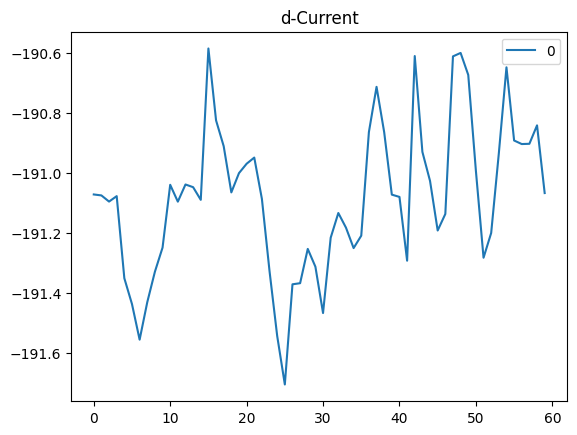

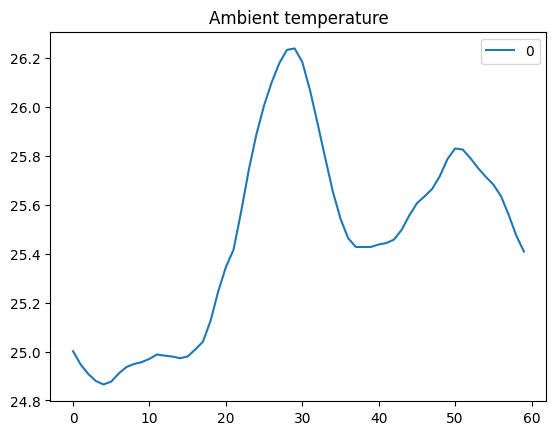

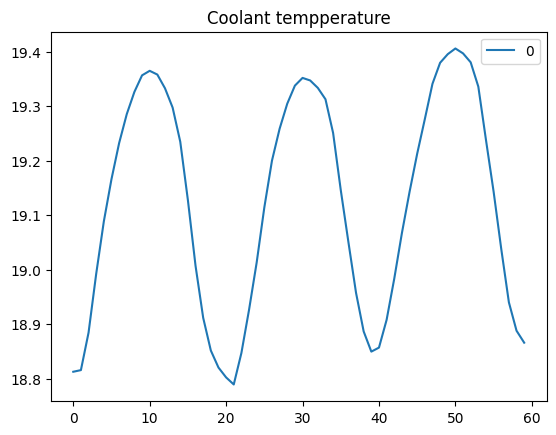

In [15]:
from matplotlib import pyplot as plt
pd.DataFrame(features[1, 0, :]).plot(title='q-Voltage')
pd.DataFrame(features[1, 1, :]).plot(title='d-Voltage')
pd.DataFrame(features[1, 2, :]).plot(title='q-Current')
pd.DataFrame(features[1, 3, :]).plot(title='d-Current')
pd.DataFrame(features[1, 4, :]).plot(title='Ambient temperature')
pd.DataFrame(features[1, 5, :]).plot(title='Coolant tempperature')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [17]:
industrial_model =  evaluate_loop(api_params=params, finetune=True)

2024-04-05 13:53:38,191 - Initialising experiment setup
2024-04-05 13:53:38,701 - Initialising Industrial Repository
2024-04-05 13:53:38,949 - Initialising Dask Server
Creating Dask Server
2024-04-05 13:53:39,731 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-04-05 13:53:39,849 - State start
2024-04-05 13:53:41,364 -   Scheduler at: inproc://10.64.4.217/23156/1
2024-04-05 13:53:41,365 -   dashboard at:  http://10.64.4.217:61769/status
2024-04-05 13:53:41,366 - Registering Worker plugin shuffle
2024-04-05 13:53:42,925 -       Start worker at: inproc://10.64.4.217/23156/4
2024-04-05 13:53:42,926 -          Listening to:          inproc10.64.4.217
2024-04-05 13:53:42,926 -           Worker name:                          0
2024-04-05 13:53:42,928 -          dashboard at:          10.64.4.217:61770
2024-04-05 13:53:42,929 - Waiting to connect to: inproc://10.64.4.217/23156/1
2024-04-05 13:53:42,929 - --------

[I 2024-04-05 14:26:16,190] A new study created in memory with name: no-name-e61db79b-e024-4281-8620-89039fb80d81


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-04-05 14:34:57,289] Trial 1 finished with value: 7.720491093351035 and parameters: {'0 || treg | max_features': 0.35381090375760316, '0 || treg | min_samples_split': 5, '0 || treg | min_samples_leaf': 15, '0 || treg | bootstrap': True}. Best is trial 1 with value: 7.720491093351035.
[I 2024-04-05 14:36:29,859] Trial 5 finished with value: 5.470439022706361 and parameters: {'0 || treg | max_features': 0.9728376540657339, '0 || treg | min_samples_split': 12, '0 || treg | min_samples_leaf': 5, '0 || treg | bootstrap': False}. Best is trial 5 with value: 5.470439022706361.
[I 2024-04-05 14:38:39,528] Trial 4 finished with value: 6.6024152078835625 and parameters: {'0 || treg | max_features': 0.05512858941524951, '0 || treg | min_samples_split': 10, '0 || treg | min_samples_leaf': 1, '0 || treg | bootstrap': True}. Best is trial 5 with value: 5.470439022706361.
[I 2024-04-05 14:38:40,444] Trial 3 finished with value: 7.242474559488555 and parameters: {'0 || treg | max_features': 0.2

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [18]:
labels = industrial_model.predict(test_data)
probs = industrial_model.predict_proba(test_data)
metrics = industrial_model.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=('r2', 'rmse', 'mae'))

In [19]:
metrics

,r2,rmse,mae
0,0.951,4.234,2.509


## AutoML approach

In [20]:
industrial_auto_model = evaluate_loop(api_params=params, finetune=False)

2024-04-05 15:08:30,213 - Initialising experiment setup
2024-04-05 15:08:30,626 - Initialising Industrial Repository
2024-04-05 15:08:30,627 - Initialising Dask Server
Creating Dask Server
2024-04-05 15:08:30,693 - State start
2024-04-05 15:08:32,213 -   Scheduler at: inproc://10.64.4.217/23156/9
2024-04-05 15:08:32,214 -   dashboard at:  http://10.64.4.217:63199/status
2024-04-05 15:08:32,215 - Registering Worker plugin shuffle
2024-04-05 15:08:33,766 -       Start worker at: inproc://10.64.4.217/23156/12
2024-04-05 15:08:33,767 -          Listening to:          inproc10.64.4.217
2024-04-05 15:08:33,768 -           Worker name:                          0
2024-04-05 15:08:33,768 -          dashboard at:          10.64.4.217:63203
2024-04-05 15:08:33,769 - Waiting to connect to: inproc://10.64.4.217/23156/9
2024-04-05 15:08:33,770 - -------------------------------------------------
2024-04-05 15:08:33,770 -               Threads:                          8
2024-04-05 15:08:33,771 -     

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2024-04-05 15:10:29,675 - IndustrialDispatcher - Number of used CPU's: 2


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000017804556310>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1615401653520
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000178029355E0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1615016324912
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000001781D786DC0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1615413531824
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy

2024-04-05 15:29:29,395 - Event loop was unresponsive in Scheduler for 3.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-04-05 15:29:29,397 - Event loop was unresponsive in Worker for 3.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000001781F03E160>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1615423571408
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000001781EF86EE0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1613655192752
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000001781DF214C0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1615423529008
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy

2024-04-05 15:55:14,010 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-04-05 15:55:14,136 - IndustrialEvoOptimizer - Generation num: 1 size: 1
2024-04-05 15:55:14,160 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=7.617 node_number=0.200>']
2024-04-05 15:55:18,435 - IndustrialDispatcher - Number of used CPU's: 2


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000178687865E0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1613569159792
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000001785B531280>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1613510632240
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000001786361DAF0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1616137523824
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy

2024-04-05 17:15:58,478 - IndustrialDispatcher - 2 individuals out of 21 in previous population were evaluated successfully. 0.09523809523809523% is a fairly small percentage of successful evaluation.
2024-04-05 17:15:58,521 - IndustrialEvoOptimizer - Generation num: 2 size: 2
2024-04-05 17:15:58,523 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=7.531 node_number=0.200>']
2024-04-05 17:15:58,524 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 0/10000 [2:05:28<?, ?gen/s]

2024-04-05 17:15:58,526 - OptimisationTimer - Composition time: 125.481 min
2024-04-05 17:15:58,530 - OptimisationTimer - Algorithm was terminated due to processing time limit
2024-04-05 17:15:58,537 - IndustrialEvoOptimizer - Generation num: 3 size: 1
2024-04-05 17:15:58,538 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=7.531 node_number=0.200>']
2024-04-05 17:15:58,540 - IndustrialEvoOptimizer - no improvements for 1 iterations
2024-04-05 17:15:58,540 - IndustrialEvoOptimizer - spent time: 125.5 min
2024-04-05 17:15:58,547 - GPComposer - GP composition finished


2024-04-05 17:15:59,425 - ApiComposer - Model generation finished
2024-04-05 17:19:46,490 - FEDOT logger - Final pipeline was fitted
2024-04-05 17:19:46,494 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [treg, quantile_extractor]}
treg - {}
quantile_extractor - {'stride': 8, 'window_size': 36}
2024-04-05 17:19:46,495 - MemoryAnalytics - Memory consumption for finish in main session: current 538.6 MiB, max: 705.2 MiB


In [21]:
auto_labels = industrial_auto_model.predict(test_data)
auto_metrics = industrial_auto_model.get_metrics(target=test_data[1],
                                                 rounding_order=3,
                                                 metric_names=('r2', 'rmse', 'mae'))

In [22]:
auto_metrics

,r2,rmse,mae
0,0.951,4.227,2.515


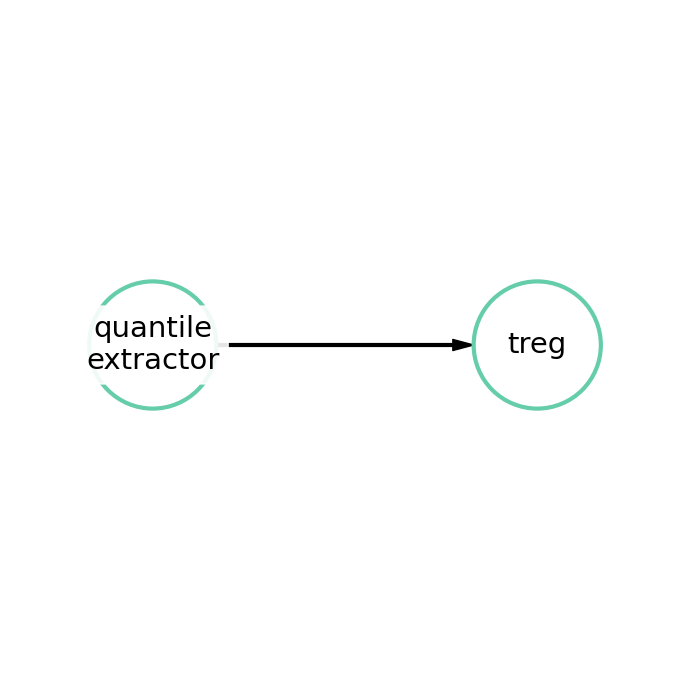

2024-04-05 17:20:38,373 - OperationsAnimatedBar - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-05 17:20:38,508 - MovieWriter ffmpeg unavailable; using Pillow instead.
2024-04-05 17:20:38,509 - Animation.save using <class 'matplotlib.animation.PillowWriter'>
2024-04-05 17:20:43,417 - OperationsAnimatedBar - The animation was saved to "D:\WORK\Repo\Industiral\IndustrialTS\results_of_experiments\history_animated_bars.gif".
2024-04-05 17:20:43,418 - FitnessBox - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-05 17:20:43,444 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-05 17:20:43,450 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the a

In [23]:
industrial_auto_model.solver.current_pipeline.show()
industrial_auto_model.plot_operation_distribution(mode='each')
industrial_auto_model.plot_fitness_by_generation()

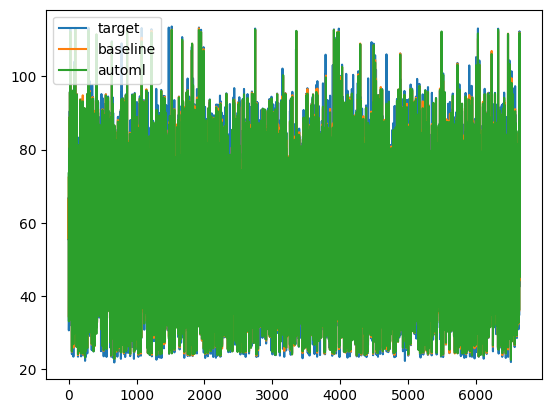

In [24]:
predictions = np.vstack([test_data[1].flatten(), labels.flatten(), auto_labels.flatten()]).T
all_prediction = pd.DataFrame(predictions, columns=['target', 'baseline', 'automl'])
all_prediction.plot()
plt.show()

## Compare with State of Art (SOTA) models

In [25]:
df = pd.read_csv(data_path+'/ts_regression_sota_results.csv',sep=';')

In [26]:
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)

In [28]:
df['Fedot_Industrial_tuned'] = metrics['rmse'][0]
df['Fedot_Industrial_AutoML'] = auto_metrics['rmse'][0]
df = df.T

In [29]:
df.sort_values('min')

algorithm,min,max,average
Fedot_Industrial_AutoML,4.227000,4.227000,4.227000
Fedot_Industrial_tuned,4.234000,4.234000,4.234000
DrCIF_RMSE,4.404898,5.643865,4.656284
InceptionT_RMSE,4.432470,4.957914,4.728375
FreshPRINCE_RMSE,4.505233,4.808177,4.650170
RotF_RMSE,4.552434,4.934061,4.698074
RIST_RMSE,4.652734,4.921443,4.782016
SingleInception_RMSE,4.773094,5.635235,5.163396
RandF_RMSE,5.021132,5.447043,5.241818
XGBoost_RMSE,5.169760,5.485085,5.312691


In [30]:
df.sort_values('max')

algorithm,min,max,average
Fedot_Industrial_AutoML,4.227000,4.227000,4.227000
Fedot_Industrial_tuned,4.234000,4.234000,4.234000
FreshPRINCE_RMSE,4.505233,4.808177,4.650170
RIST_RMSE,4.652734,4.921443,4.782016
RotF_RMSE,4.552434,4.934061,4.698074
InceptionT_RMSE,4.432470,4.957914,4.728375
RandF_RMSE,5.021132,5.447043,5.241818
XGBoost_RMSE,5.169760,5.485085,5.312691
SingleInception_RMSE,4.773094,5.635235,5.163396
DrCIF_RMSE,4.404898,5.643865,4.656284


In [31]:
df.sort_values('average')

algorithm,min,max,average
Fedot_Industrial_AutoML,4.227000,4.227000,4.227000
Fedot_Industrial_tuned,4.234000,4.234000,4.234000
FreshPRINCE_RMSE,4.505233,4.808177,4.650170
DrCIF_RMSE,4.404898,5.643865,4.656284
RotF_RMSE,4.552434,4.934061,4.698074
InceptionT_RMSE,4.432470,4.957914,4.728375
RIST_RMSE,4.652734,4.921443,4.782016
SingleInception_RMSE,4.773094,5.635235,5.163396
RandF_RMSE,5.021132,5.447043,5.241818
XGBoost_RMSE,5.169760,5.485085,5.312691
